### Домашка

1. Скачать [датасет по ссылке](https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv) (просто запустить строку ниже)

In [ ]:
!wget https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv

--2025-11-07 21:15:31--  https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102826 (100K) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>] 100.42K  --.-KB/s    in 0.002s  

2025-11-07 21:15:31 (44.9 MB/s) - ‘test.csv.1’ saved [102826/102826]



2. Открыть csv и сохранить текст в переменную (макс. балл == 1)

In [ ]:
import csv #скачиваем модуль для работы с csv
with open ('test.csv', 'r', newline='') as f: #открываем для чтения
  al = [] #список куда будут записаны все строки из файла
  text = csv.reader(f, delimiter=',')#применяем функцию считывания из файла, разделителем указали запятую
  for i in text:#построчно сохраняем полученные данные в список
    al.append(i)

3. Извлечь столбец с текстами (макс. балл == 1)

In [ ]:
done = []#сюда сохраним все коментарии
for row in al[1:]:# заходим в данные из файла, начинаем итерацию со значения с 1 индеком (названия столбцов не нужны)
  for st in row[::3]:#спускаемся в подсписок и пропускаем все значения кроме значение с 0 индексом (комментарии), оно добавляется в список
    done.append(st)

4. Построить Bag-of-Words (макс. балл == 3)

In [ ]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

bgw = []
for i in done: #итерация для каждого коментария в списке
  new = i.lower()#приводим к нижнему регистру
  new = re.sub(r'[\,.!?;:()@+#…-]', '', new)#удаляем все знаки препинания
  new = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9', '', new)#удаляем все странные символы и цифры, не было обязательно, но на меня визуализатор ругался и я убрала
  new = re.sub(r'[^\w\s]', '', new)#удаляем все эмодзи, не было обязательно, но на меня визуализатор ругался и я убрала
  bgw.append(new.split())#разделяем строчку на слова по пробелам
dic = corpora.Dictionary(bgw)#создаёт словарь со словами, к каждому присваивая свой индекс, ключ - само слово, значение - индекс
bow = [dic.doc2bow(el) for el in bgw]#создаём представление в формате bow для каждого из слов

Matrix shape: (20, 20)


Text(0.5, 36.72222222222221, 'Words')

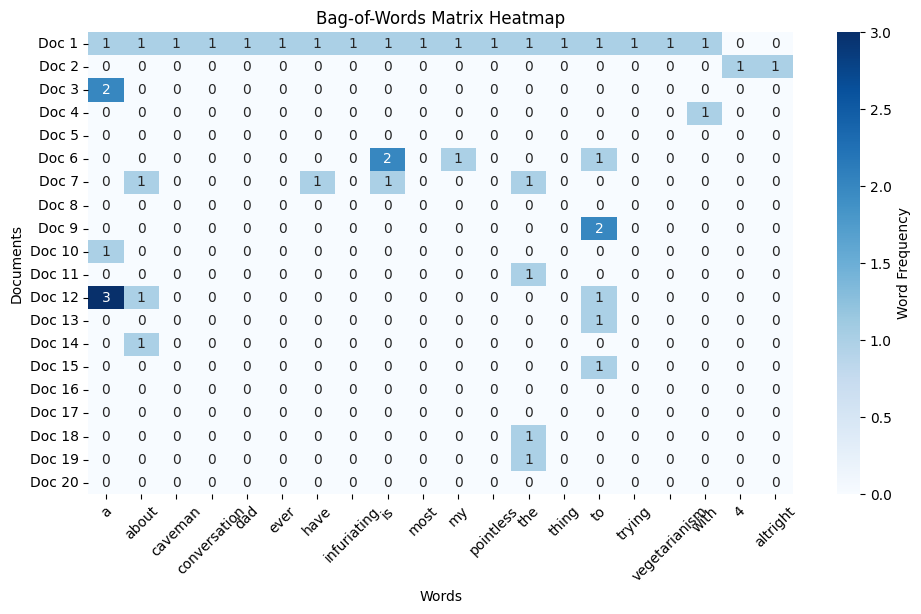

In [ ]:
def bow_to_dense(bow_corpus, dictionary):
    dense_vectors = []
    for doc in bow_corpus:
        dense_vec = [0] * len(dictionary)
        for idx, freq in doc:
            dense_vec[idx] = freq
        dense_vectors.append(dense_vec)
    return dense_vectors

dense_vectors = bow_to_dense(bow, dic)

matrix = np.array(dense_vectors)[:20, :20]
words = list(dic.token2id.keys())[:20]
doc_names = [f"Doc {i+1}" for i in range(20)]

print(f"Matrix shape: {matrix.shape}")

plt.figure(figsize=(25, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matrix,
            annot=True,
            fmt='d',
            xticklabels=words,
            yticklabels=doc_names,
            cmap='Blues',
            cbar_kws={'label': 'Word Frequency'})
plt.title('Bag-of-Words Matrix Heatmap')
plt.xticks(rotation=45)
plt.ylabel('Documents')
plt.xlabel('Words')

5. Построить TF-IDF (макс. балл == 5)

In [ ]:
import gensim
from gensim.models import TfidfModel

tfidf_model = TfidfModel(bow)#вычисляется idf для каждого слова
tfidf_corpus = tfidf_model[bow]#вычисляется tf-idf
dic_tfidf = {}

for i, doc in enumerate(tfidf_corpus):
  dic_tfidf[i] = [(dic[idx], round(score, 3)) for idx, score in doc]#для каждого документа спускаемся в его подсписок, заполняем новые словарь, где ключ - id документа, значение - словарь состоящий из всех слов в документе и tf-idf для него


#высчитываем всё вручную
def stats (bow, dic): #функция создаёт tf матрицу

  tf = np.zeros((len(bow), len(dic))) #создали матрицу из нулей рзмером: кол-во документов Х кол-во слов
  for d_idx, doc in enumerate(bow): #для каждого id документа и самого документа в bow - матрицы bag-of-words (состоящей документов, для каждого из которых записан индекса каждого элемента (слова) в документе и его встречаемости внутри этого документа), с помощью enumerate вытащили значение по отдельности для id и для частотности
    for w_idx, freq in doc: #спустились на уровень ниже (из списка списков, в подсписок), расматриваем все слова (а именно их id и частотность) внтури 1 документа
      tf[d_idx, w_idx] = freq #создаём словарь для матрицы где название это индекс документа, индекс слова в этом документе, значение это частотность слова внутри документа, в котором оно встретилось, тем самым высчитываем tf

      df = np.sum(tf > 0, axis = 0) #производим сложение значений матрицы, tf_matrix создаёт матрицу со значениями true/false, в нашем случае значение true присваевается всем индексам слов, которые встретились в документе, хотя бы 1 раз (> 0), остальным присваивается false. axis = 0 показывает, что складывание будет происходить по вертикали, высчитываем частотность для слова для всех документов, таким образом считаем df (если был бы 1, то по горизонтали - то есть высчитывалась частотность внутри одного документа)
      #df будет необходимо для вычисления idf
      #начинаем вычислять idf по формуле IDF(t) = log( N / (DF(t) + 1) ) + 1
      n = len(bow)
      idf = np.log(n / (df + 1)) + 1

      #TF-IDF находится просто перемножением tf на idf
      tf_idf = df * idf

      return tf, df, idf, tf_idf

In [ ]:
from google.colab import files

inf = stats(bow, dic)

with open('data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(inf)

files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>